# EEP 153 Project 1: Group Kitagawa

### **Countries of Investigation**: The Baltic States (Estonia, Latvia, and Lithuania)

**Description:**
Originally we wanted to see if there was convergence in population trends for countries who joined the EU in 2004 (mostly post-soviet states). What stood out to us most was a very similar pattern in the three Baltic states:  their populations were steadily increasing until 1994, after which they experienced a steep decline. Interested in this abnormal trend, we decided to narrow our countries of interest down to Estonia, Latvia, and Lithuania, and see what exactly caused this pattern after the fall of the USSR. Preliminary research revealed that after the USSR collapsed, these countries' healthcare systems rapidly deteriorated while poverty spiked (along with poverty, homelessness, and drug use). The combined effect was a major Tuberculosis (and HIV) epidemic around 1994. Since we only have more comprehensive data on these states starting in 1995, we decided to see how economic indicators have determined population growth and TB incidence since then. Although GDPPC is a poor measure of poverty (doesn't account for distribution), it's the most accurate indicator of poverty we have for these countries. Evidence suggests that GDPPC is strongly correlated with population, and we maintain that public health is one intermediary through which national income determines population trends.



## Import All Data Libraries 

In [1]:

## uncomment lines below if installation is needed 
!pip install wbdata
!pip install cufflinks
!pip install iso3166

import wbdata
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
from iso3166 import countries
import cufflinks as cf
cf.go_offline()

  Using cached wbdata-0.3.0-py3-none-any.whl (14 kB)
  Using cached typing_extensions-4.0.1-py3-none-any.whl (22 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.6.2 requires h5py~=3.1.0, but you'll have h5py 3.3.0 which is incompatible.
tensorflow 2.6.2 requires numpy~=1.19.2, but you'll have numpy 1.21.5 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you'll have typing-extensions 4.0.1 which is incompatible.


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [4]:
#if need be, use the comand below to get ISO alpha-3 country code 
#example:
countries.get('estonia').alpha3
countries.get('latvia').alpha3
countries.get('lithuania').alpha3

'LTU'

In [5]:
#Or, use the following command to get the country name, given its ISO3 code
#example
countries.get('EST').name

'Estonia'

For the following statistical exploration, we are using **source 40: Population estimates and projections** and a few  indicators within this database. To see all possible datasets, use `wbdata.get_source()`; to see all indicators in a dataset, use `wbdata.get_indicator(source=SOURCE_id)`.

## [#A] Population DataFrames
A function that returns a `panda`s DataFrame indexed by Region or Country and Year, with columns giving counts of people in different age-sex groups.

**Input Parameters:**
- **sex**: a str ('Female','Male', or 'All')
- **age_range**: a tuple with a lower bound and a higher bound, between 0 to 100
- **place**: a str (the ISO 3166-1 alpha-3 code of a country or region)
- **year** (optional): an int between 1960 to 2020; if no year is specified, the returned dataframe contains staticstics from 1960 to 2020

In [6]:
def population_df(sex, age_range, place, year = None):
    
    def age_generate(age_range):
        lower = 5* round(age_range[0] / 5)
        upper = 5* round(age_range[1] / 5)
        age_code = []
        if upper < 80:
            while lower < upper:
                age_code.append(f"{lower:02d}{lower+4:02d}")
                lower += 5
            return age_code
        else:
            while lower < 79:
                age_code.append(f"{lower:02d}{lower+4:02d}")
                lower += 5
            age_code.append('80UP')
            return age_code
        
    age_list = age_generate(age_range)
    
    def label_generate(sex, age_ls):
        prefix = sex[:2].upper()
        indicators = {}
        for i in range(len(age_ls)):
            indicators[f"SP.POP.{age_ls[i]}.{prefix}"] = f"{sex} ages {age_ls[i][:2]}-{age_ls[i][2:4]}"
        return indicators
    
    if sex != "All":
        indicator_labels = label_generate(sex, age_list)
    else:
        male_labels = label_generate("Male", age_list)
        female_labels = label_generate("Female", age_list)
        
        male_labels.update(female_labels)
        indicator_labels = male_labels
    
    pdf = wbdata.get_dataframe(indicator_labels, country = place)
    
    def clean_df(df, year = None):
        df.reset_index(inplace=True)
        df['date'] = df['date'].astype(int) 
        df.set_index('date', inplace = True)
        df['Total Population in Given Range'] = df.loc[:].sum(axis=1)
        if year != None:
            df.query(f'date=={year}', inplace = True)
            
    clean_df(pdf, year)
    return pdf


**One testing example:**

In [7]:
world_female = population_df("Female", (47,100), "WLD", year = 2002)
world_female 

,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,
2002,172436167.0,144642454.0,111974477.0,96861604.0,83341490.0,66225590.0,48357921.0,50298053.0,774137756.0


### 1.Population Tabulation for Estonia

In [8]:
estonia = population_df("All", (1,100), "EST")
estonia

,Male ages 00-04,Male ages 05-09,Male ages 10-14,Male ages 15-19,Male ages 20-24,Male ages 25-29,Male ages 30-34,Male ages 35-39,Male ages 40-44,Male ages 45-49,...,Female ages 40-44,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,,,,,,,,,,,,,
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020,35955.0,38207.0,38866.0,32086.0,29666.0,46429.0,53894.0,47694.0,45834.0,49185.0,...,43041.0,47508.0,39096.0,46754.0,47282.0,49451.0,32731.0,36274.0,58673.0,1331060.0
2019,35743.0,38648.0,38094.0,30917.0,31675.0,47720.0,53040.0,46754.0,46441.0,47285.0,...,43813.0,46207.0,40161.0,47497.0,48013.0,46798.0,33582.0,36135.0,57184.0,1326899.0
2018,34999.0,39377.0,36908.0,29869.0,34090.0,48714.0,51707.0,46136.0,47221.0,44763.0,...,44849.0,44370.0,42117.0,47681.0,48711.0,43915.0,34982.0,35906.0,55565.0,1321977.0
2017,34419.0,39930.0,35509.0,29256.0,36343.0,49672.0,50112.0,45845.0,47711.0,42507.0,...,45701.0,42799.0,44239.0,47757.0,48784.0,41924.0,35841.0,36110.0,53696.0,1317383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,50217.0,49909.0,50254.0,48789.0,44629.0,52926.0,49113.0,45928.0,30396.0,24949.0,...,47361.0,34924.0,46112.0,44101.0,40546.0,34178.0,26836.0,19395.0,16906.0,1277083.0
1963,49920.0,49550.0,49847.0,46057.0,45889.0,51739.0,48961.0,42656.0,27900.0,26256.0,...,43257.0,36964.0,46153.0,43593.0,39678.0,33274.0,26310.0,18934.0,16462.0,1258856.0
1962,49498.0,49221.0,49164.0,43385.0,47756.0,50167.0,48892.0,38997.0,25979.0,28080.0,...,39105.0,40014.0,45573.0,43164.0,38830.0,32497.0,25925.0,18495.0,15883.0,1241625.0


### 2.Population Tabulation for Latvia 

In [9]:
latvia = population_df("All", (1,100), "LVA")
latvia

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### 3.Population Tabulation for Lithuania  

In [10]:
lithuania = population_df("All", (1,100), "LTU")
lithuania

,Male ages 00-04,Male ages 05-09,Male ages 10-14,Male ages 15-19,Male ages 20-24,Male ages 25-29,Male ages 30-34,Male ages 35-39,Male ages 40-44,Male ages 45-49,...,Female ages 40-44,Female ages 45-49,Female ages 50-54,Female ages 55-59,Female ages 60-64,Female ages 65-69,Female ages 70-74,Female ages 75-79,Female ages 80-UP,Total Population in Given Range
date,,,,,,,,,,,,,,,,,,,,,
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020,76730.0,82275.0,63163.0,64723.0,70274.0,98520.0,99409.0,80264.0,82258.0,96679.0,...,83208.0,103231.0,99414.0,131402.0,108258.0,102640.0,71714.0,79711.0,127154.0,2794701.0
2019,76760.0,77629.0,62751.0,66162.0,77620.0,101721.0,95743.0,80006.0,85182.0,95768.0,...,87653.0,102864.0,104592.0,128045.0,106197.0,96053.0,73224.0,78193.0,125227.0,2794137.0
2018,76790.0,73484.0,63697.0,68381.0,85933.0,102728.0,92092.0,80930.0,88342.0,94190.0,...,92309.0,101611.0,111287.0,122793.0,105212.0,89487.0,76694.0,76341.0,123142.0,2801542.0
2017,77383.0,70874.0,65379.0,72512.0,94239.0,102309.0,89762.0,82844.0,91505.0,93784.0,...,96909.0,101579.0,117536.0,118488.0,103797.0,85426.0,80225.0,76104.0,120407.0,2828402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,146762.0,139478.0,121031.0,112532.0,114613.0,113025.0,111993.0,99662.0,70751.0,48724.0,...,98335.0,68121.0,85918.0,84095.0,75382.0,60675.0,42778.0,31363.0,26508.0,2935203.0
1963,146367.0,135523.0,118956.0,113720.0,114455.0,112854.0,111100.0,94795.0,64604.0,48656.0,...,89447.0,71179.0,86793.0,83196.0,73933.0,58085.0,42223.0,29948.0,25226.0,2898949.0
1962,145534.0,131777.0,117513.0,115215.0,113574.0,112956.0,109658.0,89288.0,58905.0,50022.0,...,80517.0,76269.0,86542.0,82309.0,72388.0,55619.0,41961.0,28176.0,24096.0,2863351.0


## [#A] Population Statistics

Using the previously defined `population_df` function, a `python` function named `population` is created to return a string with population statistics in the following form:

- In [year], there are [number] of [people/males/females] aged [low] to [high] living in [the world/region/country].


**Input Parameters:**
- **year**: a int between 1960 to 202
- **sex**: a str ('Female','Male', or 'All')
- **age_range**: a tuple with a lower bound and a higher bound, between 0 to 100
- **place**: a str (the ISO 3166-1 alpha-3 code of a country or region)

In [11]:
def population(year_defined, sex, age_range, place):
    df = population_df(sex, age_range, place, year = year_defined)
    population = df['Total Population in Given Range'].iloc[0]       
    return population


**One testing examples:**

In [12]:
population(2002, "Female", (47,100), "WLD")

774137756.0

### 1.Population of  Estonia in 1990

In [13]:
population(1990,"All", (1,100), "EST")

1569173.0

### 2.Population of  Latvia in 1990

In [14]:
population(1990,"All", (1,100), "LVA")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### 3.Population of  Lithuania in 1990

In [15]:
population(1990,"All", (1,100), "LTU")

3697836.0

### Additional Function
In additin, a `python` function named `population_statement` is created to return a string with population statistics in the following form:

- In [year], there are [number] of [people/males/females] aged [low] to [high] living in [the world/region/country].


**Input Parameters:**
- **year**: a int between 1960 to 202
- **sex**: a str ('Female','Male', or 'All')
- **age_range**: a tuple with a lower bound and a higher bound, between 0 to 100
- **place**: a str (the ISO 3166-1 alpha-3 code of a country or region)

In [16]:
def population_statement(year_defined, sex, age_range, place):
    df = population_df(sex, age_range, place, year = year_defined)
    if sex == "All":
        ppl = 'people'
    else:
        ppl = f"{sex.lower()}s"
    lower = age_range[0]
    higher = age_range[1]
    if place == 'WLD':
        country_name = 'the world'
    else:
        country_name = countries.get(place).name
    population = df['Total Population in Given Range'].iloc[0]
    
    answer = f"In {year_defined}, there are {population} {ppl} aged {lower} to {higher} living in {country_name} by approximation."
    
    return answer

**One testing examples:**

In [17]:
population_statement(2002, "Female", (47,100), "WLD")

'In 2002, there are 774137756.0 females aged 47 to 100 living in the world by approximation.'

## [#B] Population Pyramids

### Static Population Pyramid Function
The `pop_pyramid` funciton returns a static population pyramid for either the population of a single year or the populations between a year range with a specified increment of years. 

**Input Parameters:**
- **dataframe**: the name of the established dataframe for a specific country 
- **country_name**: A string (e.g. "Estonia")
- **year**: a list
    - for a single year, it's in the form [year]
    - for multiple years, it's in the form [end_year, start_year, year_increments] 


In [18]:
def pop_pyramid(dataframe, country_name, year):
    py.init_notebook_mode(connected=True)
    
    #create titles for the two different forms of population pyramid
    def title_creator(country_name, year):
        if len(year) == 1:
            title = f""
            return title 
        else:
            "Population Pyramid of Estonia, 1990-2010"
            title = f"Population Pyramid of {country_name}, {year[1]}-{year[0]} ({year[2]}-year Increments)"
            return title 
    title_ = title_creator(country_name, year)
    
    layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'),
                  title = title_)
    
    #create the age labels 
    age_ranges = []
    for i in range(0,80,5):
        age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
    age_ranges.append("80UP")
    
    #bins for one year 
    if len(year) == 1:
        bins = [go.Bar(x = dataframe.loc[year[0],:].filter(regex="Male").values,
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Men',
                   marker=dict(color='blue'),
                   hoverinfo=['x','y']
                   ),
                go.Bar(x = -dataframe.loc[year[0],:].filter(regex="Female").values,
                   y=[int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Women',
                   marker=dict(color='red'),
                   hoverinfo=['x','y']
                      )
               ]
    #bins for multiple years 
    else:
        years = range(year[0],year[1], -year[2])
        bins = [go.Bar(x = dataframe.loc[year,:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo=['x','y'],
                 opacity=0.5, 
                 marker=dict(color='green')
              )
        for year in years]
          
        bins += [go.Bar(x = -dataframe.loc[year,:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo=['x','y'],
                  opacity=0.5,
                  marker=dict(color='orange')
               )
         for year in years]

        
    py.iplot(dict(data=bins, layout=layout))
    

### Animated Population Pyramid Function
The `animate_pyramid` funciton returns an interactive population pyramid for the chosen country to illustrate the change of population over yearts.

**Input Parameters:**


In [32]:
#import data libraries 
import ipywidgets
from ipywidgets import interactive, HBox, VBox, fixed

def animate_pyramid(df, country_name, year):
    def animate_helper(df, country_name, year):
            py.init_notebook_mode(connected=True)
            
            age_ranges = []
            for i in range(0,80,5):
                age_ranges.append(f"{i:02d}"+f"{i+4:02d}")
            age_ranges.append("80UP")
            
            layout = go.Layout(barmode='overlay',
                               yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                               xaxis=go.layout.XAxis(title='Population'),
                               title = f"Population Pyramid of {country_name}, {year}")
            bins = [go.Bar(x = df.loc[year,:].filter(regex="Male").values,
                           y = [int(s[:2])+1 for s in age_ranges],
                           orientation='h',
                           name='Men',
                           marker=dict(color='yellow'),
                           hoverinfo=['x','y']
                          ),
                    go.Bar(x = -df.loc[year,:].filter(regex="Female").values,
                           y=[int(s[:2])+1 for s in age_ranges],
                           orientation='h',
                           name='Women',
                           marker=dict(color='pink'),
                           hoverinfo=['x','y'])
                   ]
            py.iplot(dict(data=bins, layout=layout))
    return ipywidgets.interact(animate_helper, df = fixed(df), year = year, country_name = country_name) 


### 1. Estonia 

In [95]:
pop_pyramid(estonia, "Estonia", [2010])
pop_pyramid(estonia, "Estonia", [2020,1960,20])
animate_pyramid(estonia, "Estonia", (1960, 2020, 1))

interactive(children=(Text(value='Estonia', description='country_name'), IntSlider(value=1990, description='ye…

<function __main__.animate_pyramid.<locals>.animate_helper(df, country_name, year)>

### 2. Latvia  

In [96]:
pop_pyramid(latvia, "Latvia", [2010])
pop_pyramid(latvia, "Latvia", [2020,1960,20])
animate_pyramid(latvia, "Latvia", (1960, 2020, 1))

NameError: name 'latvia' is not defined

### 3. Lithuania 

**Population Pyramid from 1990 to 2010 (5-year Increments)**

In [98]:
pop_pyramid(lithuania, "Lithuania", [2010])
pop_pyramid(lithuania, "Lithuania", [2020,1960,20])
animate_pyramid(lithuania, "Lithuania", (1960, 2020, 1))

interactive(children=(Text(value='Lithuania', description='country_name'), IntSlider(value=1990, description='…

<function __main__.animate_pyramid.<locals>.animate_helper(df, country_name, year)>

## [#C] Population Maps of the Baltic States



In [45]:
# Install & import new data libraries 
!pip install geopandas
!pip install pyshp


import matplotlib.pyplot as plt
import geopandas as gpd
import shapefile as shp
import seaborn as sns

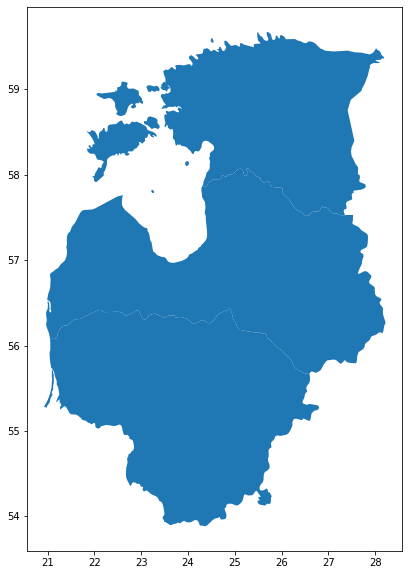

In [74]:
baltics_path = "/home/jovyan//EEP153_Exercises/Baltics Shapefiles"
map_df = gpd.read_file(baltics_path)
plt.rcParams['figure.figsize'] = [30,10]
map_df.plot();

In [75]:
population = {"SP.POP.TOTL":"Population"}
baltic = {"EST":"Estonia",
            "LVA":"Latvia",
            "LTU":"Lithuania"}

In [76]:
baltic_pop_df = wbdata.get_dataframe(population, country=baltic).squeeze()
baltic_pop_df = baltic_pop_df.unstack('country')
# Date index is of type string; change to integers
baltic_pop_df.index = baltic_pop_df.index.astype(int)
baltic_pop_df = baltic_pop_df.transpose()
baltic_pop_df.index.name
map_df.index.name
pop_map_df = map_df.merge(baltic_pop_df, left_on="NAME_ID", right_on="country", how='outer')
pop_map_df

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Admin-0 map unit,0.0,5.0,Lithuania,LTU,0.0,2.0,Sovereign country,Lithuania,LTU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Admin-0 map unit,0.0,6.0,Estonia,EST,0.0,2.0,Sovereign country,Estonia,EST,...,1327439.0,1322696.0,1317997.0,1314545.0,1315407.0,1315790.0,1317384.0,1321977.0,1326898.0,1331057.0
2,Admin-0 map unit,0.0,5.0,Latvia,LVA,0.0,2.0,Sovereign country,Latvia,LVA,...,2059709.0,2034319.0,2012647.0,1993782.0,1977527.0,1959537.0,1942248.0,1927174.0,1913822.0,1901548.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3028115.0,2987773.0,2957689.0,2932367.0,2904910.0,2868231.0,2828403.0,2801543.0,2794137.0,2794700.0


In [77]:
shape_columns = map_df[['SOVEREIGNT', 'ADMIN', 'geometry']]
merged = shape_columns.merge(baltic_pop_df, left_on="SOVEREIGNT", right_on="country", how='outer')
merged

,SOVEREIGNT,ADMIN,geometry,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Lithuania,Lithuania,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55...",2778550.0,2823550.0,2863350.0,2898950.0,2935200.0,2971450.0,3008050.0,...,3028115.0,2987773.0,2957689.0,2932367.0,2904910.0,2868231.0,2828403.0,2801543.0,2794137.0,2794700.0
1,Estonia,Estonia,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57...",1211537.0,1225077.0,1241623.0,1258857.0,1277086.0,1294566.0,1308597.0,...,1327439.0,1322696.0,1317997.0,1314545.0,1315407.0,1315790.0,1317384.0,1321977.0,1326898.0,1331057.0
2,Latvia,Latvia,"POLYGON ((27.35293 57.52760, 27.52817 57.52848...",2120979.0,2152681.0,2181586.0,2210919.0,2240623.0,2265919.0,2283217.0,...,2059709.0,2034319.0,2012647.0,1993782.0,1977527.0,1959537.0,1942248.0,1927174.0,1913822.0,1901548.0


In [78]:
merged = merged.set_index('SOVEREIGNT')

In [79]:
landareas = pd.Series([25212, 17505, 24938], index = ['Lithuania', 'Estonia', 'Latvia'])
landareas

Lithuania    25212
Estonia      17505
Latvia       24938
dtype: int64

In [80]:
merged[2020] = merged[2020] / landareas
merged[2020]

SOVEREIGNT
Lithuania    110.848009
Estonia       76.038675
Latvia        76.251023
Name: 2020, dtype: float64

In [81]:
merged

,ADMIN,geometry,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
SOVEREIGNT,,,,,,,,,,,,,,,,,,,,,
Lithuania,Lithuania,"MULTIPOLYGON (((26.59453 55.66699, 26.60383 55...",2778550.0,2823550.0,2863350.0,2898950.0,2935200.0,2971450.0,3008050.0,3044400.0,...,3028115.0,2987773.0,2957689.0,2932367.0,2904910.0,2868231.0,2828403.0,2801543.0,2794137.0,110.848009
Estonia,Estonia,"MULTIPOLYGON (((24.30616 57.86819, 24.31666 57...",1211537.0,1225077.0,1241623.0,1258857.0,1277086.0,1294566.0,1308597.0,1318946.0,...,1327439.0,1322696.0,1317997.0,1314545.0,1315407.0,1315790.0,1317384.0,1321977.0,1326898.0,76.038675
Latvia,Latvia,"POLYGON ((27.35293 57.52760, 27.52817 57.52848...",2120979.0,2152681.0,2181586.0,2210919.0,2240623.0,2265919.0,2283217.0,2301220.0,...,2059709.0,2034319.0,2012647.0,1993782.0,1977527.0,1959537.0,1942248.0,1927174.0,1913822.0,76.251023


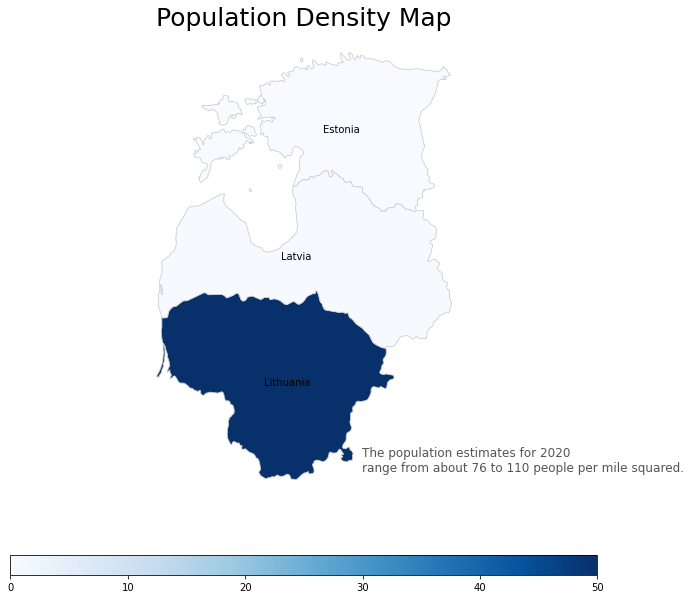

In [82]:
variable = 2020
vmin, vmax = 0, 50
fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('off')
ax.set_title('Population Density Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('The population estimates for 2020 \nrange from about 76 to 110 people per mile squared. ',xy=(26, 54),
            xycoords='data', fontsize=12, 
            color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged.iterrows():
    plt.annotate(text=row['ADMIN'], xy=row['coords'],horizontalalignment='center')

## [#C] Other Indicators 

In [49]:
eumembers = {"ESP":"Spain",
             "AUT":"Austria",
             "EST":"Estonia",
             "FIN":"Finland",
             "GRC":"Greece",
             "LVA":"Latvia",
             "LTU":"Lithuania",
             "MLT":"Malta",
             "POL":"Poland",
             "PRT":"Portugal",
             "SVK":"Slovakia",
             "SVN":"Slovenia",
            "IRL":"Ireland",
            "BGR":"Bulgaria",
            "HRV":"Croatia",
            "ROU":"Romania",
            "CZE":"Czech Republic",
            "DNK":"Denmark",
            "HUN":"Hungary",
            "POL":"Poland",
            "SWE":"Sweden",
            "BEL":"Belgium",
            "CYP":"Cyprus",
            "FRA":"France",
            "DEU":"Germany",
            "ITA":"Italy",
            "LUX":"Luxembourg",
            "NLD":"The Netherlands"}

original_15 = {"ESP":"Spain",
                "AUT":"Austria",
                "FIN":"Finland",
                "GRC":"Greece",
                "PRT":"Portugal",
                "IRL":"Ireland",
                "DNK":"Denmark",
                "SWE":"Sweden",
                "BEL":"Belgium",
                "FRA":"France",
                "DEU":"Germany",
                "ITA":"Italy",
                "LUX":"Luxembourg",
                "NLD":"The Netherlands",
                "GBR":"United Kingdom"}

baltic = {"EST":"Estonia", "LVA":"Latvia", "LTU":"Lithuania"}

In [51]:
def graph_indicator(indicator_dict, country_dict, graph_title, y_title):
    data = wbdata.get_dataframe(indicator_dict, country = country_dict).squeeze().T
    data = data.unstack('country').dropna(axis=0, how='any')
    data.index = data.index.astype(int)
    data.iplot(title = graph_title, yTitle = y_title, xTitle = 'Year')

In [50]:
def graph_log(indicator_dict, country_dict, graph_title, y_title):
    data = wbdata.get_dataframe(indicator_dict, country = country_dict).squeeze().T
    data = data.unstack('country').dropna(axis=0, how='any')
    data.index = data.index.astype(int)
    np.log(data).diff().iplot(title = graph_title, yTitle = y_title, xTitle = 'Year')

In [52]:
def eu_comparison_graph(indicator_dict, graph_title, y_title):
    all_eu = wbdata.get_dataframe(indicator_dict, country = eumembers)
    all_eu = all_eu.unstack('country').dropna(axis=0, how='any').droplevel(level=0, axis = 1)
    all_eu['EU27'] = all_eu.sum(axis=1) / 27
    
    originals = wbdata.get_dataframe(indicator_dict, country = original_15)
    originals = originals.unstack('country').dropna(axis=0, how='any').droplevel(level=0, axis = 1)
    all_eu['EU15'] = originals.sum(axis=1) / 15
    all_eu.index = all_eu.index.astype(int)
    
    comparison = all_eu[['Estonia', 'Latvia', 'Lithuania', 'EU27', 'EU15']]
    comparison.iplot(title = graph_title, yTitle = y_title, xTitle = 'Year')

In [54]:
graph_indicator({"SP.POP.TOTL":"Population"}, baltic, "Baltic Population Peak in 1990", "Population")

In [55]:
graph_log({"SP.POP.TOTL":"Population"}, baltic, "Population Growth in the Baltic Countries", "Growth Rate")

In [56]:
eu_comparison_graph({"SP.DYN.AMRT.MA":"Male Mortality"}, "Male Mortality Rates in the Baltics vs the EU", "Mortality Rate")

In [57]:
eu_comparison_graph({"SP.DYN.AMRT.FE":"Female Mortality"}, "Female Mortality Rates in the Baltics vs the EU", "Mortality Rate")

In [59]:
eu_comparison_graph({"NY.GDP.PCAP.CD":"GDP per capita"}, "GDP per capita in the Baltics vs the EU", "GDP per capita")

## [#C] Other Indicators: Tuberculosis and Poverty 

In [61]:
adults = {"SP.POP.TOTL":"total pop",
               "SP.POP.GROW":"pop growth rate",
              "SP.DYN.AMRT.MA":"male mortality",
              "SP.DYN.AMRT.FE":"female mortality",
              "SP.POP.1564.FE.ZS":"% adult female",
              "SP.POP.TOTL.FE.ZS":"% female",
              "NY.GDP.PCAP.CD":"gdppc",
              "SP.DYN.TFRT.IN":"tfr",
          "SP.POP.0014.MA.IN": "Population ages 0-14, male",
          "SP.POP.1519.MA.5Y": "Population ages 15-19, male (% of male population)",
          "SP.POP.TOTL.MA.IN": "Population, male",
          "SP.POP.0014.FE.IN": "Population ages 0-14, female",
          "SP.POP.1519.FE.5Y": "Population ages 15-19, female (% of female population)",
           "SP.POP.TOTL.FE.IN": "Population, female",
          "SP.DYN.CDRT.IN": "crude death rate",
          "SP.POP.1564.FE.IN": "Population ages 15-64, female",
          "SP.POP.6064.FE":    "Population ages 60-64, female",
          "SP.POP.TOTL.FE.IN":  "Population, female",
          "SP.POP.TOTL.MA.IN":  "Population, male"
         }

baltic = {"EST":"estonia",
             "LVA":"latvia",
             "LTU":"lithuania"
            }

peqn = wbdata.get_dataframe(adults, country = baltic)
peqn['adult male pop'] = peqn['Population, male'] - (peqn['Population ages 0-14, male'] + (peqn['Population ages 15-19, male (% of male population)']/100)*peqn['Population, male'])
peqn['adult female pop'] = peqn['Population, female'] - (peqn['Population ages 0-14, female'] + (peqn['Population ages 15-19, female (% of female population)']/100)*peqn['Population, female'])
peqn['adult pop'] = peqn['adult male pop'] + peqn['adult female pop']   

peqn['male mortality rate'] = peqn['male mortality']/1000
peqn['female mortality rate'] = peqn['female mortality']/1000  
peqn['total mortality rate'] = (peqn['male mortality rate']*peqn['Population, male'] + peqn['female mortality rate']*peqn['Population, female'])/peqn['total pop']

peqn["% adult female"] = peqn["% adult female"]*peqn["% female"]/100
peqn['mompop'] = peqn['Population ages 15-64, female']-peqn['Population ages 60-64, female']
peqn['momshare'] = peqn['mompop']/peqn['total pop']

peqn.reset_index(inplace=True)
peqn['date'] = peqn['date'].astype(int)
peqn.set_index(['date', 'country'],inplace=True)
peqn = peqn.dropna(axis=0, how='any')

peqn = peqn.drop(columns = ['Population ages 0-14, male', 'Population ages 15-19, male (% of male population)', 'Population ages 0-14, female', 'Population ages 15-19, female (% of female population)', 'Population ages 15-64, female', 'Population ages 60-64, female'])
peqn_clean = peqn.drop(columns = ['male mortality', 'female mortality', '% adult female', '% female', 'adult male pop', 'adult female pop', 'adult pop', 'male mortality rate', 'female mortality rate'])
peqn_clean

,,total pop,pop growth rate,gdppc,tfr,"Population, male","Population, female",crude death rate,total mortality rate,mompop,momshare
date,country,,,,,,,,,,
1995,Estonia,1436634.0,-1.785400,3134.389753,1.38,664904.0,771730.0,14.5,0.251556,447311.0,0.311360
1996,Estonia,1415594.0,-1.475365,3380.926302,1.37,655373.0,760221.0,13.4,0.216094,442208.0,0.312383
1997,Estonia,1399535.0,-1.140919,3682.952301,1.32,649018.0,750517.0,13.3,0.214128,437348.0,0.312495
1998,Estonia,1386156.0,-0.960559,4093.392477,1.28,644332.0,741824.0,14.0,0.224434,432662.0,0.312131
1999,Estonia,1390244.0,0.294482,4140.936602,1.30,647619.0,742625.0,13.4,0.209563,433831.0,0.312054
...,...,...,...,...,...,...,...,...,...,...,...
2015,Lithuania,2904910.0,-0.940754,14258.229335,1.70,1337721.0,1567189.0,14.4,0.158899,901910.0,0.310478
2016,Lithuania,2868231.0,-1.270695,14998.125060,1.69,1322120.0,1546111.0,14.3,0.155664,878890.0,0.306422
2017,Lithuania,2828403.0,-1.398322,16843.699655,1.63,1305326.0,1523077.0,14.2,0.140692,854187.0,0.302003


In [83]:
# Trying to replicate the equation for population in year t+1 given indicators for year t

peqn_clean['surviving adults'] = (1 - (peqn_clean['crude death rate']/1000))*peqn_clean['total pop']
peqn_clean['next yr predicted total pop'] = peqn_clean['surviving adults'] + peqn_clean['mompop']*peqn_clean['tfr']

prediction = peqn_clean[['total pop', 'next yr predicted total pop']]
prediction = prediction.rename(columns = {'next yr predicted total pop': 'pred total pop'})
pred_shift = prediction.groupby('country')['pred total pop'].shift()
pred_shift = pd.DataFrame(pred_shift)
prediction['pred total pop'] = pred_shift['pred total pop']


prediction['pop resid'] = prediction['pred total pop'] - prediction['total pop']
prediction = prediction.dropna(axis=0, how='any')
prediction

,,total pop,pred total pop,pop resid
date,country,,,
1996,Estonia,1415594.0,2.033092e+06,6.174980e+05
1997,Estonia,1399535.0,2.002450e+06,6.029150e+05
1998,Estonia,1386156.0,1.958221e+06,5.720645e+05
1999,Estonia,1390244.0,1.920557e+06,5.303132e+05
2000,Estonia,1396985.0,1.935595e+06,5.386100e+05
...,...,...,...,...
2015,Lithuania,2904910.0,4.392918e+06,1.488008e+06
2016,Lithuania,2868231.0,4.396326e+06,1.528095e+06
2017,Lithuania,2828403.0,4.312539e+06,1.484136e+06


In [85]:
import plotly.express as px
prediction.reset_index(inplace = True)

fig = px.line(prediction, x='date', y=['total pop', 'pred total pop'] , color='country')
fig.update_traces(textposition="bottom right")
fig.show()

#gap due to net migration (incomplete data), or did i fuck something up?

Is the residual between predicted total pop and actual total pop in year t+1 due to net migration (for which we have incomplete data) or did I mess something up? 
- Next step: compare residual to net migration for the three years in Estonia for which we have complete data

Looking at relationship between TB incidence, population, and income. Know income strongly associated with TB - when USSR collapsed, so did it's healthcare and welfare systems. High rates of poverty, homelessness, and drug use --> TB epidemic. 

Wanted to use better indicators for poverty than gdppc, but we have most robust (and accurate) data on gdppc.

In [86]:
ind = {"SH.TBS.INCD" : "Incidence of tuberculosis (per 100,000 people)",
        "NY.GDP.PCAP.CD":"GDP per capita",
        "SI.POV.LMIC": "Poverty headcount ratio at $3.20 a day (2011 PPP) (% of population)",
       "SP.POP.TOTL":"Total population",
       "SP.POP.GROW":"Population Growth Rate",
       "SP.DYN.AMRT.FE":"Female Mortality"}
    
baltic = {"EST":"Estonia",
             "LVA":"Latvia",
             "LTU":"Lithuania"
         }

data = wbdata.get_dataframe(ind, country = baltic)

# Make years ints instead of strings
data.reset_index(inplace=True)
data['date'] = data['date'].astype(int)
data = data.dropna(axis=0, how='any')

data['Log GDP per capita'] = np.log(data['GDP per capita'])
data['Log TB incidence'] = np.log(data['Incidence of tuberculosis (per 100,000 people)'])

In [87]:
import statsmodels.api as sm

#simple linear regression of log TB incidence on log gdppc, for all three baltic states
y_3i = data['Log TB incidence']
X_3i = sm.add_constant(data[['Log GDP per capita']])
model_3i = sm.OLS(y_3i, X_3i)
results_3i = model_3i.fit(cov_type='HC1')
results_3i.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     28.93
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           3.09e-06
Time:                        23:11:05   Log-Likelihood:                -16.367
No. Observations:                  44   AIC:                             36.73
Df Residuals:                      42   BIC:                             40.30
Df Model:                           1                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.6698      1.629      7.776      0.000       9.476      15.863
Log GDP per capita    -0.9337      0.174     -5.378      0.000      -1.274      -0.593
==============================================================================
Omnibus:                        3.423   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                2.058
Skew:                          -0.295   Prob(JB):                        0.357
Kurtosis:                       2.121   Cond. No.                         307.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [88]:
#now, want to see how gdppc well predicts tb incidence in each individual country, starting with estonia

est = data[data['country']=='Estonia']

y_3i = est['Log TB incidence']
X_3i = sm.add_constant(est[['Log GDP per capita']])
model_3i = sm.OLS(y_3i, X_3i)
results_3i = model_3i.fit(cov_type='HC1')
results_3i.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     43.80
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           1.67e-05
Time:                        23:11:18   Log-Likelihood:                 1.4315
No. Observations:                  15   AIC:                             1.137
Df Residuals:                      13   BIC:                             2.553
Df Model:                           1                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5353      1.352      9.272      0.000       9.886      15.185
Log GDP per capita    -0.9590      0.145     -6.618      0.000      -1.243      -0.675
==============================================================================
Omnibus:                        0.836   Durbin-Watson:                   0.581
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.374
Skew:                           0.378   Prob(JB):                        0.829
Kurtosis:                       2.840   Cond. No.                         310.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [89]:
lva = data[data['country']=='Latvia']

y_3i = lva['Log TB incidence']
X_3i = sm.add_constant(lva[['Log GDP per capita']])
model_3i = sm.OLS(y_3i, X_3i)
results_3i = model_3i.fit(cov_type='HC1')
results_3i.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=14



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     29.51
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           0.000152
Time:                        23:11:31   Log-Likelihood:                 5.2893
No. Observations:                  14   AIC:                            -6.579
Df Residuals:                      12   BIC:                            -5.300
Df Model:                           1                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.4343      1.156      9.030      0.000       8.169      12.699
Log GDP per capita    -0.6894      0.127     -5.433      0.000      -0.938      -0.441
==============================================================================
Omnibus:                        0.083   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.959   Jarque-Bera (JB):                0.106
Skew:                           0.085   Prob(JB):                        0.948
Kurtosis:                       2.608   Cond. No.                         330.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [90]:
ltu = data[data['country']=='Lithuania']

y_3i = ltu['Log TB incidence']
X_3i = sm.add_constant(ltu[['Log GDP per capita']])
model_3i = sm.OLS(y_3i, X_3i)
results_3i = model_3i.fit(cov_type='HC1')
results_3i.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     8.368
Date:                Wed, 09 Feb 2022   Prob (F-statistic):             0.0126
Time:                        23:11:39   Log-Likelihood:                 10.200
No. Observations:                  15   AIC:                            -16.40
Df Residuals:                      13   BIC:                            -14.98
Df Model:                           1                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.9296      1.309      6.060      0.000       5.365      10.494
Log GDP per capita    -0.3999      0.138     -2.893      0.004      -0.671      -0.129
==============================================================================
Omnibus:                        0.340   Durbin-Watson:                   0.529
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.465
Skew:                           0.256   Prob(JB):                        0.792
Kurtosis:                       2.306   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [91]:
#by incorporating binary indicators for country to our model, we can compare the relationship in each country
#drop Lithuania from model --> use as baseline against which we compare Estonia and Latvia

bdummies = pd.get_dummies(data['country'], prefix='', prefix_sep='')
data_wdummies = data[['country', 'date', 'Log TB incidence', 'Log GDP per capita', 'Total population']].join(bdummies)

y_3g = data_wdummies['Log TB incidence']
X_3g = sm.add_constant(data_wdummies.drop(columns=['Log TB incidence', 'Lithuania', 'country', 'date', 'Total population']))
model_3g= sm.OLS(y_3g, X_3g)
results_3g = model_3g.fit(cov_type='HC1')
results_3g.summary()


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Log TB incidence   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     41.07
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.75e-12
Time:                        23:11:49   Log-Likelihood:                 11.363
No. Observations:                  44   AIC:                            -14.73
Df Residuals:                      40   BIC:                            -7.590
Df Model:                           3                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.7197      1.001     10.713      0.000       8.758      12.681
Log GDP per capita    -0.6946      0.104     -6.695      0.000      -0.898      -0.491
Estonia               -0.7262      0.068    -10.683      0.000      -0.859      -0.593
Latvia                -0.2370      0.064     -3.722      0.000      -0.362      -0.112
==============================================================================
Omnibus:                        0.642   Durbin-Watson:                   0.490
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.283
Skew:                          -0.194   Prob(JB):                        0.868
Kurtosis:                       3.066   Cond. No.                         318.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

<AxesSubplot:xlabel='Log GDP per capita', ylabel='Log TB incidence'>

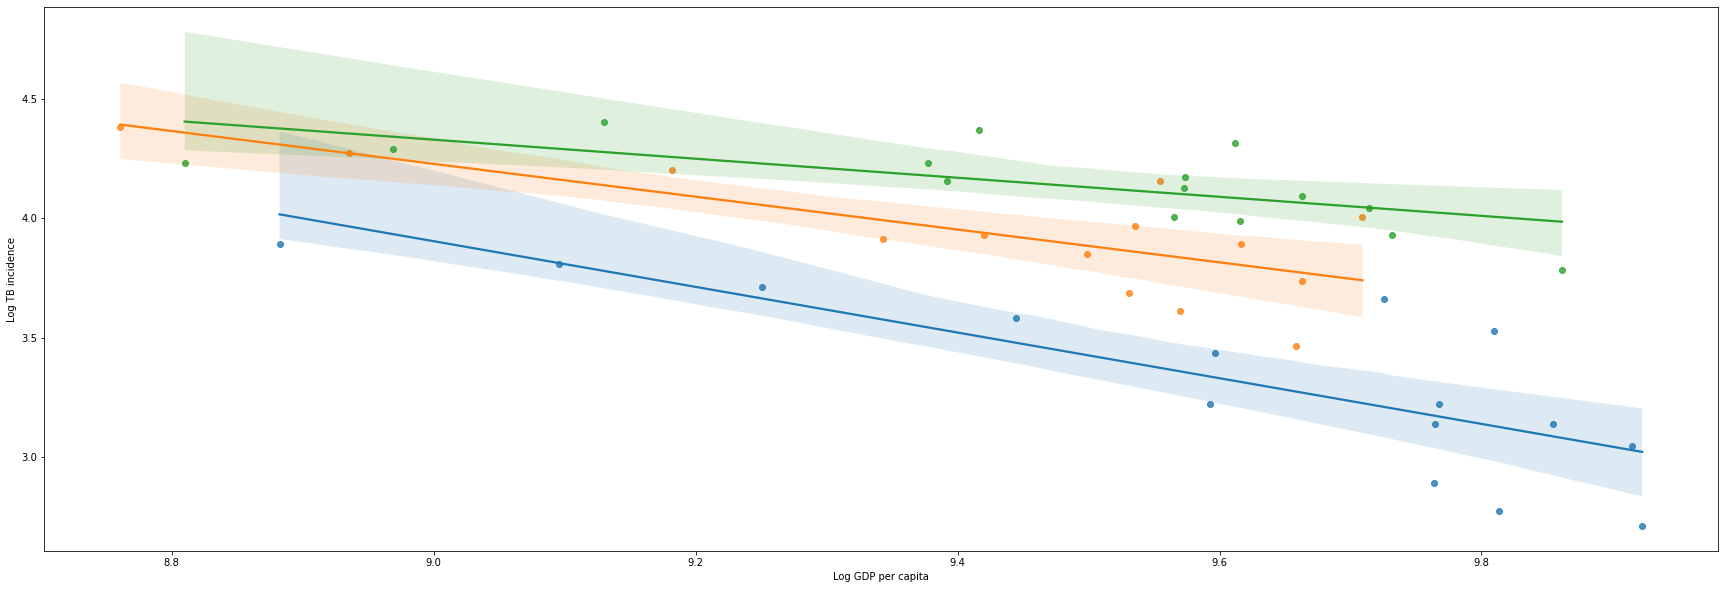

In [99]:
#now we're just plotting some regression lines to visualize the relationships in question

import seaborn as sns

sns.regplot(x='Log GDP per capita', y='Log TB incidence', data=est)
sns.regplot(x='Log GDP per capita', y='Log TB incidence', data=lva)
sns.regplot(x='Log GDP per capita', y='Log TB incidence', data=ltu)

#not sure how to add legend but i'll figure that out!

In [92]:
est.reset_index(inplace=True)
est.set_index(['date'],inplace=True)

est.iplot(kind='scatter', mode='markers', symbol='circle-dot', bestfit=True, 
         x='Log GDP per capita',y='Log TB incidence',
         text=est.reset_index('date')['date'].values.tolist(),
         xTitle='Log GDP per capita',yTitle='Log TB incidence',
         title='Estonia')

lva.reset_index(inplace=True)
lva.set_index(['date'],inplace=True)

lva.iplot(kind='scatter', mode='markers', symbol='circle-dot', bestfit=True, 
         x='Log GDP per capita',y='Log TB incidence',
         text=lva.reset_index('date')['date'].values.tolist(),
         xTitle='Log GDP per capita',yTitle='Log TB incidence',
         title='Latvia')


ltu.reset_index(inplace=True)
ltu.set_index(['date'],inplace=True)

ltu.iplot(kind='scatter', mode='markers', symbol='circle-dot', bestfit=True, 
         x="Log GDP per capita",y='Log TB incidence',
         text=ltu.reset_index('date')['date'].values.tolist(),
         xTitle='Log GDP per capita',yTitle='Log TB incidence',
         title='Lithuania')


In [93]:
data['Log Total Pop'] = np.log(data['Total population'])
est = data[data['country']=='Estonia']
lva = data[data['country']=='Latvia']
ltu = data[data['country']=='Lithuania']

est[['Log Total Pop', 'Log TB incidence', 'country', 'date']].iplot(
    x='date', y='Log Total Pop', mode='lines+markers', secondary_y = 'Log TB incidence',
    secondary_y_title='Log TB incidence', xTitle='date', yTitle='Log Total Pop',
    text='country', title='Log total population and log TB incidence over time, Estonia')

lva[['Log Total Pop', 'Log TB incidence', 'country', 'date']].iplot(
    x='date', y='Log Total Pop', mode='lines+markers', secondary_y = 'Log TB incidence',
    secondary_y_title='Log TB incidence', xTitle='date', yTitle='Log Total Pop',
    text='country', title='Log total population and log TB incidence over time, Latvia')

ltu[['Log Total Pop', 'Log TB incidence', 'country', 'date']].iplot(
    x='date', y='Log Total Pop', mode='lines+markers', secondary_y = 'Log TB incidence',
    secondary_y_title='Log TB incidence', xTitle='date', yTitle='Log Total Pop',
    text='country', title='Log total population and log TB incidence over time, Lithuania')


# Ignore the Rest

In [74]:
print(lithuania.query("date == 2008").sum(axis=0))

Male ages 00-04                      74531.0
Male ages 05-09                      77085.0
Male ages 10-14                     101177.0
Male ages 15-19                     121772.0
Male ages 20-24                     117971.0
Male ages 25-29                     105428.0
Male ages 30-34                     103289.0
Male ages 35-39                     109503.0
Male ages 40-44                     115974.0
Male ages 45-49                     119999.0
Male ages 50-54                     101240.0
Male ages 55-59                      79587.0
Male ages 60-64                      67884.0
Male ages 65-69                      62887.0
Male ages 70-74                      53403.0
Male ages 75-79                      36470.0
Male ages 80-UP                      28579.0
Female ages 00-04                    71248.0
Female ages 05-09                    72897.0
Female ages 10-14                    96098.0
Female ages 15-19                   117427.0
Female ages 20-24                   114910.0
Female age

In [60]:
import numpy as np

variable_new1 = {"SP.DYN.CBRT.IN":"Birth rate"
                  }

# Three letter codes come from wbdata.get_country()
countries_new1 = {
             "ESP":"Spain",
                      "AUT":"Austria",
                      "EST":"Estonia",
                      "FIN":"Finland",
                      "GRC": "Greece",
                      "LVA": "Latvia",
                      "LTU": "Lithuania",
                      "MLT": "Malta",
                      "POL": "Poland",
                      "PRT": "Portugal",
                      "SVK": "Slovakia",
                      "SVN":"Slovenia",
                    "USA":"US",
                    "CHN":"China"
    
            }

new = wbdata.get_dataframe(variable_new1, country = countries_new1).squeeze()

new = new.unstack('country')
# Date index is of type string; change to integers
new.index = new.index.astype(int)

# Differences (over time) in logs give us growth rates
new.iplot(title="EU Birth Rate",
                        yTitle="Rate",xTitle='Year')